In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import cv2                         # To read and manipulate images
import matplotlib.pyplot as plt    # Python 2D plotting library
%matplotlib inline  
from sklearn.preprocessing import LabelEncoder
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from time import time
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import copy
from torch.autograd import Variable
import torch.nn.functional as F
import pickle
from cnn_finetune import make_model
from time import sleep

In [2]:
TRAIN_PATH = 'data/CAX_Superhero_Train/'
TEST_PATH = 'data/CAX_Superhero_Test/'
superhero_dic = {'Ant-Man':'ant_man', 'Aquaman':'aqua_man', 'Avengers':'avengers', 'Batman':'bat_man', 
                 'Black Panther':'black_panther', 'Captain America':'captain_america', 'Catwoman':'cat_woman',
                 'Ghost Rider':'ghostrider', 'Hulk':'hulk', 'Iron Man':'iron_man', 'Spiderman':'spider_man', 
                 'Superman':'super_man'}

labelencoder_dic = {0: 'ant_man', 1: 'aqua_man', 2: 'avengers', 3: 'bat_man', 4: 'black_panther', 5: 'captain_america', 
                    6: 'cat_woman', 7: 'ghostrider', 8: 'hulk', 9: 'iron_man', 10: 'spider_man', 11: 'super_man'}

IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = 160

train_df = pd.read_csv('data/train_df.csv')
test_df = pd.read_csv('data/test_df.csv')

torch.random.manual_seed(10);
torch.cuda.manual_seed(10)

In [3]:
#Dataset for PyTorch
class SuperheroesDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
        self.transform = transform
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        img = Image.open(self.x[idx])
        img = img.convert('RGB')
        if self.transform is not None:
            img = self.transform(img)           
        label = self.y[idx]
        out = (img, label)
        return out

#Train model
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=2):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data[0] * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

# This is a little utility that we'll use to reset the model if we want to re-initialize all our parameters
def reset(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()    
        
def predict(test_loader, model):
    model.eval()       #Sets the module in evaluation mode
    predictions = []
    
    for i, data in enumerate(tqdm(test_loader)):
        inputs, _ = data
        if use_gpu:
            inputs = Variable(inputs.cuda())
        else:
            inputs = Variable(inputs)
            
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        predictions.append(preds[0])
        sleep(0.01)
    return predictions

def submit_prediction(test_load, model, path):
    predictions = predict(test_load, model)
    d = {'filename': test_df['img_name'], 'Superhero': predictions}
    predict_df = pd.DataFrame(d)
    predict_df = predict_df[['filename', 'Superhero']]
    predict_df['filename'] = predict_df['filename'].map(lambda x: str(x)[:-4])
    predict_df.replace({"Superhero": labelencoder_dic}, inplace=True)

    submission = pd.read_csv('data/Superhero_3375_SampleSubmission.csv')

    # find filename in predict and insert superhero in submission
    for i in tqdm(range(submission.shape[0])):
        filename = submission['filename'].iloc[i]
        submission['Superhero'].iloc[i] = predict_df['Superhero'][predict_df['filename'] == filename].values[0]

    submission.to_csv(path, index=False)

In [4]:
transform_data = transforms.Compose([transforms.Resize(IMG_SIZE),transforms.CenterCrop(IMG_SIZE),transforms.ToTensor()])

transform_train = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     #transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])
transform_test = transforms.Compose([transforms.Resize(IMG_SIZE),
                                     transforms.CenterCrop(IMG_SIZE),
                                     transforms.ToTensor(),
                                     #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                    ])

use_gpu = torch.cuda.is_available()

labelencoder = LabelEncoder()

x_train_df = train_df['img_path'].values
y_train_df = train_df['superhero'].values
y_train_df = labelencoder.fit_transform(y_train_df)
x_test_df = test_df['img_path'].values

x_train, x_valid, y_train, y_valid = train_test_split(x_train_df, y_train_df, test_size=0.2, random_state=42, 
                                                      shuffle=True, stratify=y_train_df)
x_test = x_test_df
y_test = np.zeros_like(x_test)

batch_size = 32
train_set = SuperheroesDataset(x_train, y_train, transform_train)
train_load = DataLoader(train_set,batch_size=batch_size, pin_memory=True)
valid_set = SuperheroesDataset(x_valid, y_valid, transform_test)
valid_load = DataLoader(valid_set,batch_size=batch_size, pin_memory=True)
test_set = SuperheroesDataset(x_test, y_test, transform_test)
test_load = DataLoader(test_set,batch_size=1, pin_memory=True)

image_datasets = {'train':train_set, 'val':valid_set}
dataloaders    = {'train':train_load, 'val':valid_load}
dataset_sizes  = {'train':len(train_set), 'val':len(valid_set)}

criterion = nn.CrossEntropyLoss()

In [5]:
#Train model
def train_model_batch(model, criterion, optimizer, scheduler=None, num_epochs=2, batch_accum=1):
    since = time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0
    loss_log = {'train':{}, 'val':{}}
    acc_log = {'train':{}, 'val':{}}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            loss_mini_batch = 0

            # Iterate over data.
            for i, data in enumerate(dataloaders[phase]):

                inputs, labels = data

                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())

                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)                

                if phase == 'train':
                    loss.backward()

                running_loss += loss.data[0]*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


                if (i+1) % batch_accum == 0:
                    optimizer.step()
                    optimizer.zero_grad()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            loss_log[phase][epoch] = epoch_loss
            acc_log[phase][epoch] = epoch_acc 

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_epoch = epoch
        print('lr: ',optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}, epoch {:d}'.format(best_acc, best_epoch))
    

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    # plot graphs
    for phase in loss_log:
        lists = sorted(loss_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(1)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Loss')
    
    for phase in acc_log:
        lists = sorted(acc_log[phase].items()) # sorted by key, return a list of tuples
        x, y = zip(*lists) # unpack a list of pairs into two tuples
        plt.figure(2)
        plt.plot(x,y)
    plt.legend(['train', 'val'])
    plt.title('Accuracy')
    
    return model, loss_log, acc_log

In [11]:
model_ft = make_model('vgg11_bn', num_classes=12, pretrained=True, input_size=(160, 160))
model_ft.cuda();

Epoch 0/29
----------
train Loss: 4.9379 Acc: 0.1473
val Loss: 2.2854 Acc: 0.2254
lr:  0.001

Epoch 1/29
----------
train Loss: 2.2835 Acc: 0.2154
val Loss: 2.2128 Acc: 0.2447
lr:  0.001

Epoch 2/29
----------
train Loss: 2.2188 Acc: 0.2386
val Loss: 2.1560 Acc: 0.2576
lr:  0.001

Epoch 3/29
----------
train Loss: 2.1761 Acc: 0.2586
val Loss: 2.2142 Acc: 0.2429
lr:  0.001

Epoch 4/29
----------
train Loss: 2.1485 Acc: 0.2711
val Loss: 2.1180 Acc: 0.2668
lr:  0.001

Epoch 5/29
----------
train Loss: 2.1116 Acc: 0.2740
val Loss: 2.1114 Acc: 0.2613
lr:  0.001

Epoch 6/29
----------
train Loss: 2.1050 Acc: 0.2745
val Loss: 2.0420 Acc: 0.2640
lr:  0.001

Epoch 7/29
----------
train Loss: 2.0694 Acc: 0.2736
val Loss: 2.0399 Acc: 0.2695
lr:  0.001

Epoch 8/29
----------
train Loss: 2.0343 Acc: 0.2846
val Loss: 2.0256 Acc: 0.2815
lr:  0.001

Epoch 9/29
----------
train Loss: 2.0390 Acc: 0.2734
val Loss: 2.0547 Acc: 0.2787
lr:  0.001

Epoch 10/29
----------
train Loss: 1.9898 Acc: 0.3012
val Lo

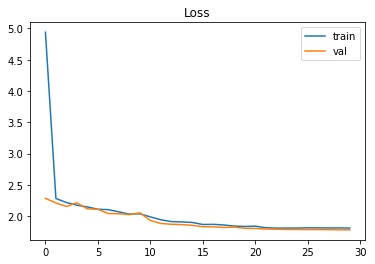

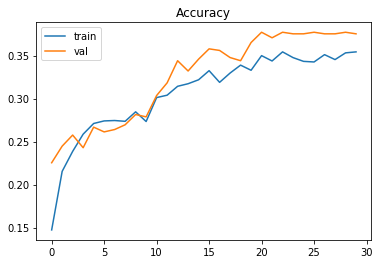

In [10]:
# vgg11_bn, batch_size=128, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg11, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

Epoch 0/4
----------
train Loss: 2.1881 Acc: 0.2347
val Loss: 3.0245 Acc: 0.2631
lr:  0.0001

Epoch 1/4
----------
train Loss: 1.8443 Acc: 0.3757
val Loss: 2.1682 Acc: 0.3643
lr:  0.0001

Epoch 2/4
----------
train Loss: 1.6470 Acc: 0.4542
val Loss: 1.6393 Acc: 0.4443
lr:  0.0001

Epoch 3/4
----------
train Loss: 1.5337 Acc: 0.4871
val Loss: 1.5525 Acc: 0.5152
lr:  0.0001

Epoch 4/4
----------
train Loss: 1.4338 Acc: 0.5274
val Loss: 1.7490 Acc: 0.5069
lr:  0.0001

Training complete in 2m 33s
Best val Acc: 0.515179, epoch 3


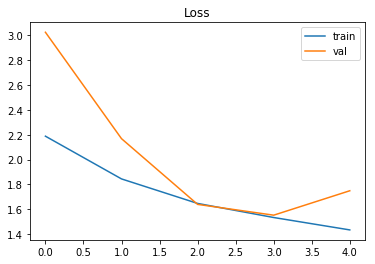

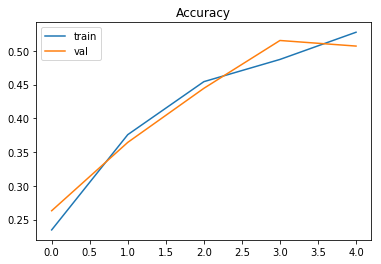

In [14]:
# vgg11_bn, batch_size=128, lr=0.001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg11, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5, batch_accum=8)

Epoch 0/19
----------
train Loss: 2.1874 Acc: 0.2372
val Loss: 2.9658 Acc: 0.2843
lr:  0.0001

Epoch 1/19
----------
train Loss: 1.8413 Acc: 0.3879
val Loss: 1.9023 Acc: 0.4140
lr:  0.0001

Epoch 2/19
----------
train Loss: 1.6230 Acc: 0.4655
val Loss: 1.5733 Acc: 0.4931
lr:  0.0001

Epoch 3/19
----------
train Loss: 1.5148 Acc: 0.4956
val Loss: 1.6318 Acc: 0.5051
lr:  0.0001

Epoch 4/19
----------
train Loss: 1.4087 Acc: 0.5387
val Loss: 1.9594 Acc: 0.4600
lr:  0.0001

Epoch 5/19
----------
train Loss: 1.3215 Acc: 0.5695
val Loss: 1.3850 Acc: 0.5538
lr:  0.0001

Epoch 6/19
----------
train Loss: 1.2732 Acc: 0.5792
val Loss: 1.6089 Acc: 0.5198
lr:  0.0001

Epoch 7/19
----------
train Loss: 1.2088 Acc: 0.6012
val Loss: 1.3072 Acc: 0.5842
lr:  0.0001

Epoch 8/19
----------
train Loss: 1.0747 Acc: 0.6482
val Loss: 1.7327 Acc: 0.5455
lr:  0.0001

Epoch 9/19
----------
train Loss: 0.9766 Acc: 0.6896
val Loss: 1.3766 Acc: 0.5695
lr:  0.0001

Epoch 10/19
----------
train Loss: 0.9424 Acc: 0.6

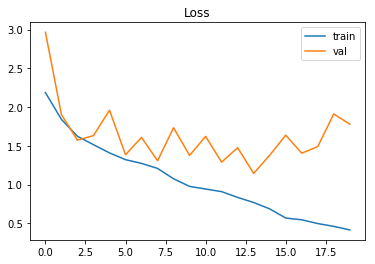

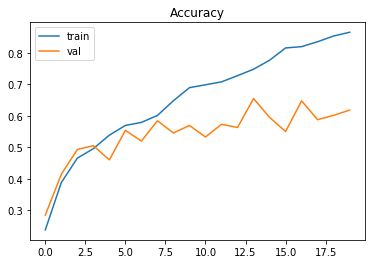

In [16]:
# vgg11_bn, batch_size=256, lr=0.0001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
model_ft.apply(reset)
model_vgg11, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, num_epochs=20, batch_accum=8)

In [17]:
torch.save(model_vgg11, 'log/model_vgg11_1')

Epoch 0/9
----------
train Loss: 0.6213 Acc: 0.8037
val Loss: 0.9694 Acc: 0.6946
lr:  1e-05

Epoch 1/9
----------
train Loss: 0.4810 Acc: 0.8569
val Loss: 0.9246 Acc: 0.7139
lr:  1e-05

Epoch 2/9
----------
train Loss: 0.4288 Acc: 0.8741
val Loss: 0.9229 Acc: 0.7305
lr:  1e-05

Epoch 3/9
----------
train Loss: 0.3798 Acc: 0.8873
val Loss: 0.9372 Acc: 0.7286
lr:  1e-05

Epoch 4/9
----------
train Loss: 0.3523 Acc: 0.8925
val Loss: 0.9501 Acc: 0.7268
lr:  1e-05

Epoch 5/9
----------
train Loss: 0.3303 Acc: 0.9029
val Loss: 0.9383 Acc: 0.7415
lr:  1e-05

Epoch 6/9
----------
train Loss: 0.2990 Acc: 0.9123
val Loss: 0.9594 Acc: 0.7360
lr:  1e-05

Epoch 7/9
----------
train Loss: 0.2710 Acc: 0.9174
val Loss: 0.9731 Acc: 0.7378
lr:  1e-05

Epoch 8/9
----------
train Loss: 0.2432 Acc: 0.9321
val Loss: 0.9948 Acc: 0.7378
lr:  1e-05

Epoch 9/9
----------
train Loss: 0.2204 Acc: 0.9386
val Loss: 0.9870 Acc: 0.7341
lr:  1e-05

Training complete in 5m 17s
Best val Acc: 0.741490, epoch 5


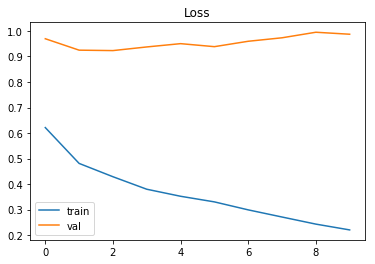

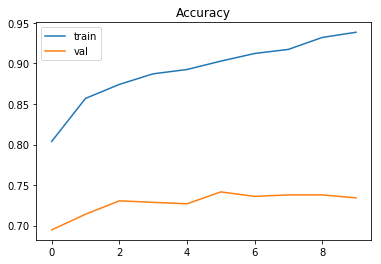

In [18]:
# vgg11_bn, batch_size=256, lr=0.0001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)
model_vgg11, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, num_epochs=10, batch_accum=8)

In [19]:
torch.save(model_vgg11, 'log/model_vgg11_2')

In [6]:
model_vgg11_2 = torch.load('log/model_vgg11_2')

Epoch 0/9
----------
train Loss: 0.3089 Acc: 0.9059
val Loss: 0.9550 Acc: 0.7286
lr:  1e-05

Epoch 1/9
----------
train Loss: 0.2719 Acc: 0.9172
val Loss: 0.9623 Acc: 0.7351
lr:  1e-05

Epoch 2/9
----------
train Loss: 0.2450 Acc: 0.9305
val Loss: 0.9722 Acc: 0.7351
lr:  1e-05

Epoch 3/9
----------
train Loss: 0.2266 Acc: 0.9386
val Loss: 0.9865 Acc: 0.7369
lr:  1e-05

Epoch 4/9
----------
train Loss: 0.1994 Acc: 0.9485
val Loss: 1.0079 Acc: 0.7406
lr:  1e-05

Epoch 5/9
----------
train Loss: 0.1794 Acc: 0.9524
val Loss: 0.9972 Acc: 0.7341
lr:  1e-05

Epoch 6/9
----------
train Loss: 0.1603 Acc: 0.9597
val Loss: 1.0147 Acc: 0.7341
lr:  1e-05

Epoch 7/9
----------
train Loss: 0.1489 Acc: 0.9630
val Loss: 1.0979 Acc: 0.7387
lr:  1e-05

Epoch 8/9
----------
train Loss: 0.1304 Acc: 0.9685
val Loss: 1.0960 Acc: 0.7360
lr:  1e-05

Epoch 9/9
----------
train Loss: 0.1140 Acc: 0.9715
val Loss: 1.1825 Acc: 0.7231
lr:  1e-05

Training complete in 5m 22s
Best val Acc: 0.740570, epoch 4


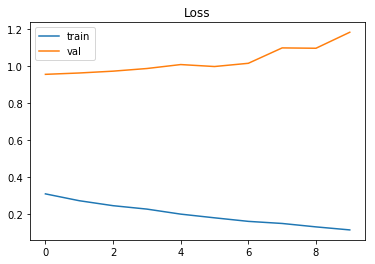

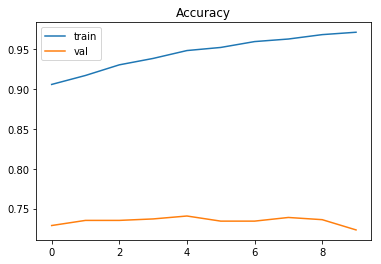

In [9]:
# vgg11_bn, batch_size=256, lr=0.0001, pretrained=True
optimizer_ft = optim.Adam(model_vgg11_2.parameters(), lr=0.00001)
model_vgg11_3, loss_log, acc_log = train_model_batch(model_vgg11_2, criterion, optimizer_ft, num_epochs=10, batch_accum=8)

Epoch 0/29
----------
train Loss: 2.2273 Acc: 0.2184
val Loss: 2.1374 Acc: 0.3036
lr:  0.0001

Epoch 1/29
----------
train Loss: 1.8563 Acc: 0.3801
val Loss: 2.5114 Acc: 0.3496
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.6781 Acc: 0.4436
val Loss: 1.9119 Acc: 0.4057
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.5562 Acc: 0.4864
val Loss: 1.8987 Acc: 0.4388
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.4316 Acc: 0.5214
val Loss: 1.7887 Acc: 0.4600
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.3719 Acc: 0.5527
val Loss: 1.7310 Acc: 0.4986
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.2740 Acc: 0.5803
val Loss: 2.0045 Acc: 0.4554
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.2043 Acc: 0.5994
val Loss: 1.3531 Acc: 0.5814
lr:  0.0001

Epoch 8/29
----------
train Loss: 1.0888 Acc: 0.6445
val Loss: 1.3340 Acc: 0.5842
lr:  0.0001

Epoch 9/29
----------
train Loss: 1.0259 Acc: 0.6647
val Loss: 1.3582 Acc: 0.5750
lr:  0.0001

Epoch 10/29
----------
train Loss: 0.9660 Acc: 0.6

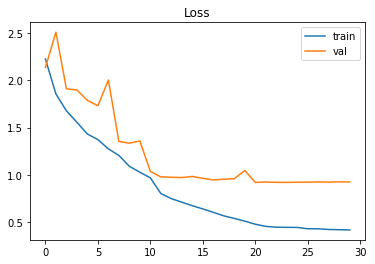

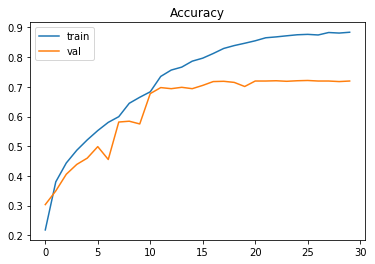

In [12]:
# vgg11_bn, batch_size=128, lr=0.0001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg11, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

In [8]:
model_vgg11_2 = torch.load('log/model_vgg11_2')

In [9]:
pred_test = predict(test_load, model_vgg11_2)

100%|██████████████████████████████████████████████████████████████████████████████| 3375/3375 [01:11<00:00, 47.05it/s]


In [10]:
submit_prediction(test_load, model_vgg11_2, 'submit.csv')

100%|████████████████████████████████████████████████████████████████████████████| 3375/3375 [00:02<00:00, 1491.57it/s]


In [11]:
model_ft = make_model('vgg11_bn', num_classes=12, pretrained=True, input_size=(160, 160), dropout_p=0.5)
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.2616 Acc: 0.2101
val Loss: 2.2083 Acc: 0.2861
lr:  0.0001

Epoch 1/29
----------
train Loss: 1.9591 Acc: 0.3362
val Loss: 2.0239 Acc: 0.3579
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.7988 Acc: 0.3960
val Loss: 2.3892 Acc: 0.2944
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.6210 Acc: 0.4611
val Loss: 2.2571 Acc: 0.3698
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.5122 Acc: 0.4952
val Loss: 1.6099 Acc: 0.5161
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.3947 Acc: 0.5407
val Loss: 1.5318 Acc: 0.5271
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.3095 Acc: 0.5683
val Loss: 1.6743 Acc: 0.5189
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.2531 Acc: 0.5877
val Loss: 1.6540 Acc: 0.5216
lr:  0.0001

Epoch 8/29
----------
train Loss: 1.1968 Acc: 0.6111
val Loss: 1.5078 Acc: 0.5235
lr:  0.0001

Epoch 9/29
----------
train Loss: 1.1452 Acc: 0.6208
val Loss: 1.4876 Acc: 0.5106
lr:  0.0001

Epoch 10/29
----------
train Loss: 1.0692 Acc: 0.6

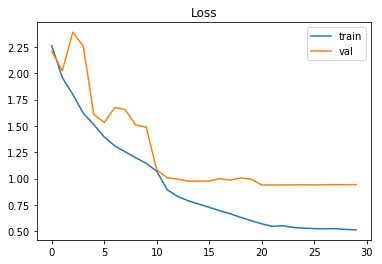

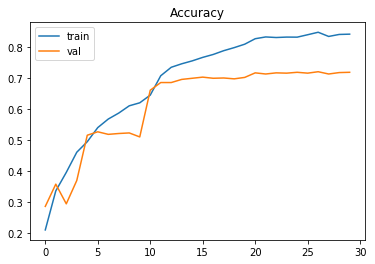

In [12]:
# vgg11_bn, batch_size=128, lr=0.0001, pretrained=True, dropout_p=0.5
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg11, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

In [6]:
model_ft = make_model('vgg13_bn', num_classes=12, pretrained=True, input_size=(160, 160))
model_ft.cuda();

Epoch 0/39
----------
train Loss: 2.2463 Acc: 0.2151
val Loss: 2.3799 Acc: 0.2751
lr:  0.0001

Epoch 1/39
----------
train Loss: 1.9450 Acc: 0.3426
val Loss: 1.8162 Acc: 0.3689
lr:  0.0001

Epoch 2/39
----------
train Loss: 1.7263 Acc: 0.4243
val Loss: 1.9218 Acc: 0.4112
lr:  0.0001

Epoch 3/39
----------
train Loss: 1.6253 Acc: 0.4641
val Loss: 1.8664 Acc: 0.4517
lr:  0.0001

Epoch 4/39
----------
train Loss: 1.4952 Acc: 0.5064
val Loss: 1.7905 Acc: 0.4379
lr:  0.0001

Epoch 5/39
----------
train Loss: 1.3854 Acc: 0.5442
val Loss: 1.5178 Acc: 0.5455
lr:  0.0001

Epoch 6/39
----------
train Loss: 1.3128 Acc: 0.5711
val Loss: 1.7764 Acc: 0.4434
lr:  0.0001

Epoch 7/39
----------
train Loss: 1.2341 Acc: 0.5985
val Loss: 1.5487 Acc: 0.5235
lr:  0.0001

Epoch 8/39
----------
train Loss: 1.1413 Acc: 0.6323
val Loss: 1.5152 Acc: 0.5189
lr:  0.0001

Epoch 9/39
----------
train Loss: 1.1030 Acc: 0.6440
val Loss: 2.0382 Acc: 0.4913
lr:  0.0001

Epoch 10/39
----------
train Loss: 1.0526 Acc: 0.6

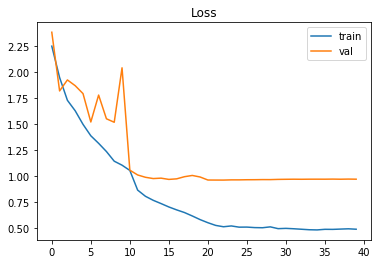

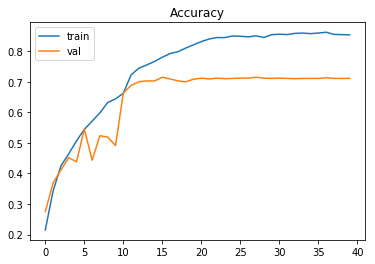

In [7]:
# vgg13_bn, batch_size=32, lr=0.0001, pretrained=True
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg11, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=40, batch_accum=8)

In [9]:
model_ft = make_model('vgg11_bn', num_classes=12, pretrained=True, input_size=(160, 160))
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.1990 Acc: 0.2428
val Loss: 2.3634 Acc: 0.3146
lr:  0.0001

Epoch 1/29
----------
train Loss: 1.8458 Acc: 0.3801
val Loss: 2.5638 Acc: 0.3707
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.6507 Acc: 0.4473
val Loss: 2.3135 Acc: 0.3533
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.5682 Acc: 0.4798
val Loss: 1.5832 Acc: 0.4775
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.3942 Acc: 0.5439
val Loss: 1.6089 Acc: 0.4738
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.2865 Acc: 0.5732
val Loss: 1.7709 Acc: 0.4756
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.2233 Acc: 0.6012
val Loss: 1.4825 Acc: 0.5179
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.0773 Acc: 0.6417
val Loss: 2.1844 Acc: 0.4903
lr:  0.0001

Epoch 8/29
----------
train Loss: 0.9958 Acc: 0.6776
val Loss: 1.7311 Acc: 0.4692
lr:  0.0001

Epoch 9/29
----------
train Loss: 0.8817 Acc: 0.7027
val Loss: 1.5467 Acc: 0.5593
lr:  0.0001

Epoch 10/29
----------
train Loss: 0.7963 Acc: 0.7

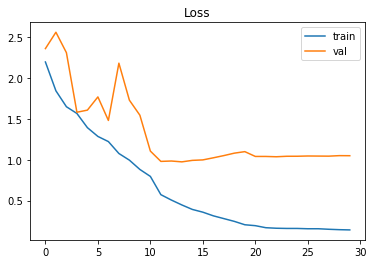

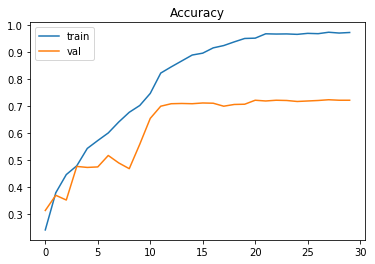

In [10]:
# vgg11_bn, batch_size=128, lr=0.0001, pretrained=True, no transforms.RandomHorizontalFlip()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg11, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

Epoch 0/9
----------
train Loss: 2.2064 Acc: 0.2329
val Loss: 1.9440 Acc: 0.3533
lr:  0.0001

Epoch 1/9
----------
train Loss: 1.8319 Acc: 0.4001
val Loss: 3.2771 Acc: 0.3100
lr:  0.0001

Epoch 2/9
----------
train Loss: 1.6734 Acc: 0.4478
val Loss: 1.8551 Acc: 0.4204
lr:  0.0001

Epoch 3/9
----------
train Loss: 1.4987 Acc: 0.5044
val Loss: 1.7612 Acc: 0.4397
lr:  0.0001

Epoch 4/9
----------
train Loss: 1.4112 Acc: 0.5361
val Loss: 1.7421 Acc: 0.4554
lr:  0.0001

Epoch 5/9
----------
train Loss: 1.2889 Acc: 0.5826
val Loss: 1.8841 Acc: 0.4857
lr:  0.0001

Epoch 6/9
----------
train Loss: 1.1837 Acc: 0.6160
val Loss: 1.4970 Acc: 0.5161
lr:  0.0001

Epoch 7/9
----------
train Loss: 1.1115 Acc: 0.6434
val Loss: 1.8840 Acc: 0.5023
lr:  0.0001

Epoch 8/9
----------
train Loss: 1.0844 Acc: 0.6576
val Loss: 1.6367 Acc: 0.4609
lr:  0.0001

Epoch 9/9
----------
train Loss: 0.9449 Acc: 0.6940
val Loss: 1.3950 Acc: 0.5759
lr:  0.0001

Training complete in 5m 3s
Best val Acc: 0.575897, epoch 9
E

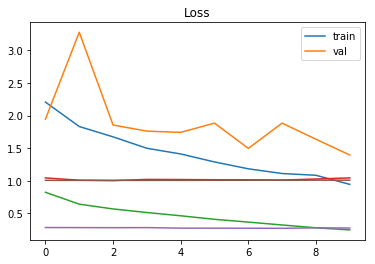

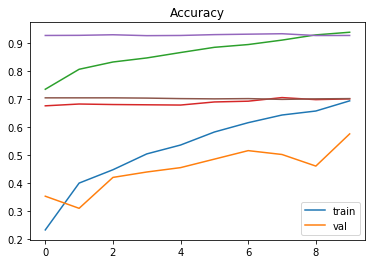

In [12]:
model_ft.apply(reset)
lr = 0.0001
loss_log_all = []
acc_log_all = []
for i in range(3):
    lr *= 10**(-i)
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr)
    model_vgg11, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10, batch_accum=8)
    loss_log_all.append(loss_log)
    acc_log_all.append(acc_log)
    model_ft = model_vgg11

In [7]:
model_ft = make_model('vgg16_bn', num_classes=12, pretrained=True, input_size=(160, 160))
model_ft.cuda();

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\Андрей/.torch\models\vgg16_bn-6c64b313.pth
100%|███████████████████████████████████████████████████████████████| 553507836/553507836 [01:22<00:00, 6746448.87it/s]


Epoch 0/29
----------
train Loss: 2.2416 Acc: 0.2145
val Loss: 3.7934 Acc: 0.2493
lr:  0.0001

Epoch 1/29
----------
train Loss: 1.9231 Acc: 0.3440
val Loss: 2.7477 Acc: 0.3054
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.7139 Acc: 0.4202
val Loss: 2.1901 Acc: 0.4112
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.6381 Acc: 0.4554
val Loss: 1.8266 Acc: 0.4664
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.4866 Acc: 0.5085
val Loss: 2.3755 Acc: 0.4425
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.3752 Acc: 0.5534
val Loss: 1.3949 Acc: 0.5483
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.2697 Acc: 0.5851
val Loss: 1.7563 Acc: 0.4793
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.1261 Acc: 0.6369
val Loss: 1.3074 Acc: 0.5713
lr:  0.0001

Epoch 8/29
----------
train Loss: 1.0104 Acc: 0.6677
val Loss: 1.3064 Acc: 0.5851
lr:  0.0001

Epoch 9/29
----------
train Loss: 0.9390 Acc: 0.6954
val Loss: 2.1195 Acc: 0.5198
lr:  0.0001

Epoch 10/29
----------
train Loss: 0.9598 Acc: 0.6

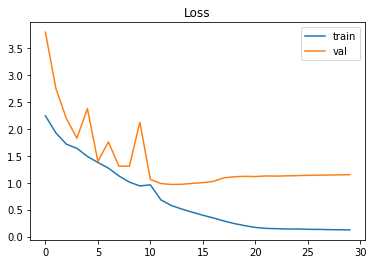

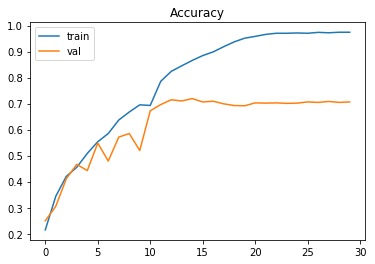

In [9]:
# vgg16_bn, batch_size=128, lr=0.0001, pretrained=True, no transforms.RandomHorizontalFlip()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optaimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg16, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

Epoch 0/9
----------
train Loss: 2.2555 Acc: 0.2075
val Loss: 2.3692 Acc: 0.2971
lr:  0.0001

Epoch 1/9
----------
train Loss: 1.9596 Acc: 0.3320
val Loss: 2.3052 Acc: 0.3036
lr:  0.0001

Epoch 2/9
----------
train Loss: 1.7496 Acc: 0.4089
val Loss: 2.1921 Acc: 0.3698
lr:  0.0001

Epoch 3/9
----------
train Loss: 1.6112 Acc: 0.4632
val Loss: 1.7785 Acc: 0.4517
lr:  0.0001

Epoch 4/9
----------
train Loss: 1.4976 Acc: 0.4995
val Loss: 2.1938 Acc: 0.3901
lr:  0.0001

Epoch 5/9
----------
train Loss: 1.4399 Acc: 0.5306
val Loss: 2.1142 Acc: 0.4269
lr:  0.0001

Epoch 6/9
----------
train Loss: 1.3373 Acc: 0.5557
val Loss: 1.4508 Acc: 0.5290
lr:  0.0001

Epoch 7/9
----------
train Loss: 1.2151 Acc: 0.6008
val Loss: 1.7272 Acc: 0.4793
lr:  0.0001

Epoch 8/9
----------
train Loss: 1.0635 Acc: 0.6484
val Loss: 1.5948 Acc: 0.4710
lr:  0.0001

Epoch 9/9
----------
train Loss: 0.9505 Acc: 0.6903
val Loss: 1.9129 Acc: 0.4324
lr:  0.0001

Training complete in 8m 10s
Best val Acc: 0.528979, epoch 6


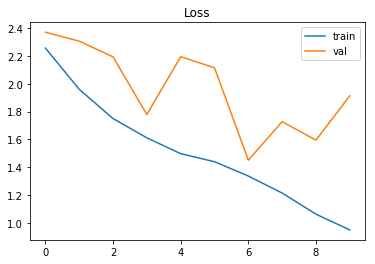

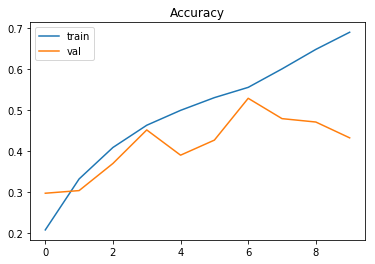

In [14]:
# vgg16_bn, batch_size=128, lr=0.0001, pretrained=True, no transforms.RandomHorizontalFlip()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
model_ft.apply(reset)
model_vgg16, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, num_epochs=10, batch_accum=8)

Epoch 0/9
----------
train Loss: 1.1918 Acc: 0.6125
val Loss: 1.1612 Acc: 0.6311
lr:  1e-05

Epoch 1/9
----------
train Loss: 1.0235 Acc: 0.6643
val Loss: 1.1261 Acc: 0.6421
lr:  1e-05

Epoch 2/9
----------
train Loss: 0.9516 Acc: 0.6889
val Loss: 1.1036 Acc: 0.6541
lr:  1e-05

Epoch 3/9
----------
train Loss: 0.9006 Acc: 0.7052
val Loss: 1.0969 Acc: 0.6569
lr:  1e-05

Epoch 4/9
----------
train Loss: 0.8531 Acc: 0.7220
val Loss: 1.0944 Acc: 0.6559
lr:  1e-05

Epoch 5/9
----------
train Loss: 0.7952 Acc: 0.7448
val Loss: 1.1193 Acc: 0.6486
lr:  1e-05

Epoch 6/9
----------
train Loss: 0.7408 Acc: 0.7648
val Loss: 1.1308 Acc: 0.6550
lr:  1e-05

Epoch 7/9
----------
train Loss: 0.6828 Acc: 0.7879
val Loss: 1.1324 Acc: 0.6587
lr:  1e-05

Epoch 8/9
----------
train Loss: 0.6186 Acc: 0.8113
val Loss: 1.1476 Acc: 0.6661
lr:  1e-05

Epoch 9/9
----------
train Loss: 0.5524 Acc: 0.8318
val Loss: 1.1794 Acc: 0.6587
lr:  1e-05

Training complete in 8m 12s
Best val Acc: 0.666053, epoch 8


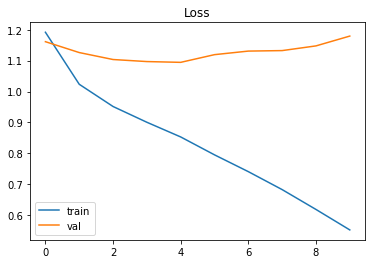

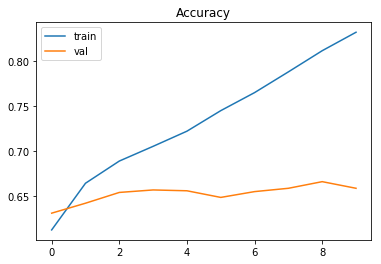

In [15]:
# vgg16_bn, batch_size=128, lr=0.0001, pretrained=True, no transforms.RandomHorizontalFlip()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.00001)
model_vgg16, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, num_epochs=10, batch_accum=8)

In [7]:
model_ft = make_model('vgg19_bn', num_classes=12, pretrained=True, input_size=(160, 160))
model_ft.cuda();

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to C:\Users\Андрей/.torch\models\vgg19_bn-c79401a0.pth
100%|███████████████████████████████████████████████████████████████| 574769405/574769405 [01:26<00:00, 6646209.45it/s]


Epoch 0/29
----------
train Loss: 2.3095 Acc: 0.1829
val Loss: 4.9430 Acc: 0.2024
lr:  0.0001

Epoch 1/29
----------
train Loss: 2.0545 Acc: 0.2809
val Loss: 2.7675 Acc: 0.3063
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.8326 Acc: 0.3755
val Loss: 2.5006 Acc: 0.3772
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.6512 Acc: 0.4468
val Loss: 1.6687 Acc: 0.4379
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.5225 Acc: 0.5002
val Loss: 1.4983 Acc: 0.5161
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.4585 Acc: 0.5253
val Loss: 1.8046 Acc: 0.4269
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.2988 Acc: 0.5769
val Loss: 1.5085 Acc: 0.5455
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.1963 Acc: 0.6086
val Loss: 4.0727 Acc: 0.3569
lr:  0.0001

Epoch 8/29
----------
train Loss: 1.3019 Acc: 0.5796
val Loss: 4.1808 Acc: 0.3707
lr:  0.0001

Epoch 9/29
----------
train Loss: 1.1793 Acc: 0.6160
val Loss: 2.7285 Acc: 0.4167
lr:  0.0001

Epoch 10/29
----------
train Loss: 1.1206 Acc: 0.6

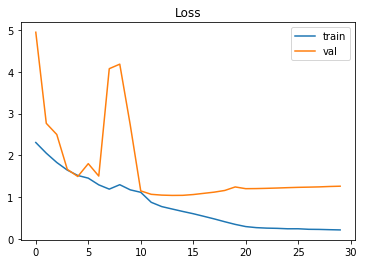

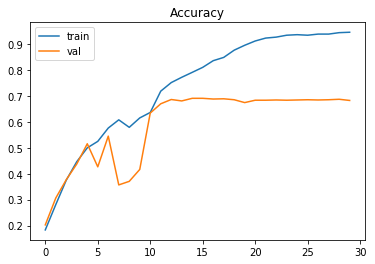

In [12]:
# vgg19_bn, batch_size=32, lr=0.0001, pretrained=True, no transforms.RandomHorizontalFlip()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg16, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

In [6]:
model_ft = make_model('vgg19_bn', num_classes=12, pretrained=True, input_size=(160, 160), dropout_p=0.5)
model_ft.cuda();

Epoch 0/29
----------
train Loss: 2.2944 Acc: 0.1864
val Loss: 2.2177 Acc: 0.2760
lr:  0.0001

Epoch 1/29
----------
train Loss: 2.0286 Acc: 0.3021
val Loss: 2.1252 Acc: 0.3349
lr:  0.0001

Epoch 2/29
----------
train Loss: 1.8858 Acc: 0.3537
val Loss: 2.1029 Acc: 0.3293
lr:  0.0001

Epoch 3/29
----------
train Loss: 1.7868 Acc: 0.3958
val Loss: 2.1895 Acc: 0.3956
lr:  0.0001

Epoch 4/29
----------
train Loss: 1.6382 Acc: 0.4533
val Loss: 1.6370 Acc: 0.4738
lr:  0.0001

Epoch 5/29
----------
train Loss: 1.5416 Acc: 0.4915
val Loss: 1.4768 Acc: 0.5189
lr:  0.0001

Epoch 6/29
----------
train Loss: 1.4027 Acc: 0.5359
val Loss: 1.7555 Acc: 0.4729
lr:  0.0001

Epoch 7/29
----------
train Loss: 1.3242 Acc: 0.5626
val Loss: 1.5849 Acc: 0.5051
lr:  0.0001

Epoch 8/29
----------
train Loss: 1.2036 Acc: 0.6079
val Loss: 1.7308 Acc: 0.4839
lr:  0.0001

Epoch 9/29
----------
train Loss: 1.1444 Acc: 0.6238
val Loss: 1.8010 Acc: 0.4747
lr:  0.0001

Epoch 10/29
----------
train Loss: 1.1403 Acc: 0.6

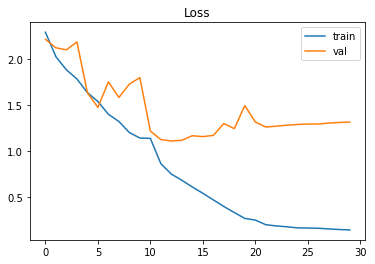

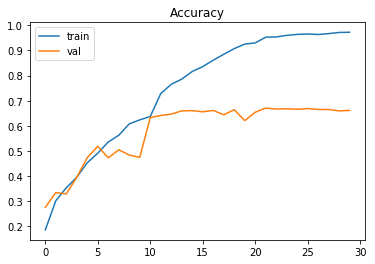

In [7]:
# vgg19_bn, batch_size=32, lr=0.0001, pretrained=True, no transforms.RandomHorizontalFlip()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.0001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)
model_ft.apply(reset)
model_vgg19, loss_log, acc_log = train_model_batch(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=30, batch_accum=8)

In [13]:
model_ft = make_model('vgg', num_classes=12, pretrained=True, input_size=(160, 160))
model_ft.cuda();

ValueError: model_name vgg not found. Available model_name values: resnet18, resnet34, resnet50, resnet101, resnet152, densenet121, densenet169, densenet201, densenet161, alexnet, vgg11, vgg11_bn, vgg13, vgg13_bn, vgg16, vgg16_bn, vgg19, vgg19_bn, squeezenet1_0, squeezenet1_1, inception_v3, resnext101_32x4d, resnext101_64x4d, nasnetalarge, inceptionresnetv2, dpn68, dpn68b, dpn92, dpn98, dpn131, dpn107, inception_v4, xception